In [1]:
import zipfile
import datetime
import string
import math
import os
import re

import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection
import keras
import numpy as np

import keras_ocr
from faker import Faker
import transformers

assert tf.test.is_gpu_available(), 'No GPU is available.'

russian_chars = 'АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя'
data_dir = '.'
alphabet = russian_chars+ '!?. '
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
# fonts = keras_ocr.data_generation.get_fonts(
#     alphabet='',
#     cache_dir=data_dir
# )
backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir)

2024-03-01 16:39:22.173608: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 16:39:22.173650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 16:39:22.174697: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 16:39:22.180277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-01 16:39:22.922924: W tensorflow/compiler/tf2

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Looking for ./backgrounds.zip


2024-03-01 16:39:24.554157: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 16:39:24.588127: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 16:39:24.588669: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
len(backgrounds)

1034

In [3]:
all_fonts = []
for address, dirs, files in os.walk('../keras-ocr/r_fonts'):
    for file in files:
        if file.endswith('.ttf') or file.endswith('.otf'):
            all_fonts.append(os.path.join(address, file))
            
base_fonts = []
for address, dirs, files in os.walk('../keras-ocr/r_fonts1'):
    for file in files:
        if file.endswith('.ttf') or file.endswith('.otf'):
            base_fonts.append(os.path.join(address, file))
            
fonts = all_fonts + base_fonts*((len(backgrounds)-len(all_fonts))//len(base_fonts))
len(all_fonts), len(base_fonts), len(fonts)

(416, 11, 1032)

In [4]:
def text_generator():
    while True:
        yield Faker(['ru']).sentence()

print(f'The first generated text is:', next(text_generator()))

The first generated text is: Хозяйка изображать спичка.


The first generated validation image (below) contains:
 Кид
ать казн
ь сустав
простра
нство п
еребив


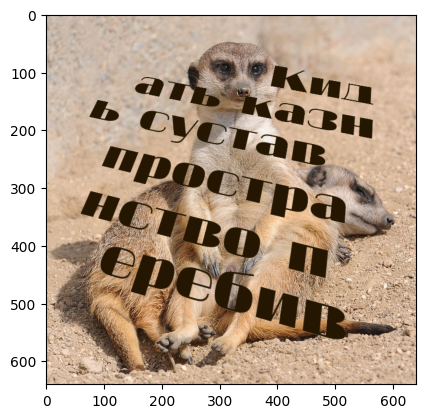

In [5]:
def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

background_splits = get_train_val_test_split(backgrounds)
font_splits = get_train_val_test_split(fonts)

image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=640,
        width=640,
        text_generator=text_generator(),
        font_groups={
            alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(60, 120),
        margin=50,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    )  for current_fonts, current_backgrounds in zip(
        font_splits,
        background_splits
    )
]

# See what the first validation image looks like.
image, lines = next(image_generators[1])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:\n', text)
plt.imshow(image)

In [6]:
input_shape = (32,128)

In [7]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

sequence_length = 5
recognizer_batch_size = 64
vector_alphabet = ['[bos]','[eos]'] + list(recognizer_alphabet)



def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

def custom_split(input_string):
    split = tf.strings.unicode_split(input_string, 'UTF-8')

    if len(split.shape) <2:
        split = tf.expand_dims(split, 0)
        
    # print(split.shape)
    
    starts = tf.constant(['[bos]']*split.shape[0], dtype=tf.string)
    starts = tf.reshape(starts, [split.shape[0], 1])
    
    ends = tf.constant(['[eos]']*split.shape[0], dtype=tf.string)
    ends = tf.reshape(ends, [split.shape[0], 1])
    
    split = tf.concat([starts, split, ends], axis=1)

    return split

vectorization = keras.layers.TextVectorization(
    output_mode="int",
    output_sequence_length=sequence_length,
    vocabulary=vector_alphabet,
    split=custom_split,
    standardize=custom_standardization
)

2024-03-01 16:39:25.302779: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 16:39:25.303090: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 16:39:25.303267: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
vectorization('Cdhb dhfgffs')

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[2, 1, 1, 1, 1]])>

In [9]:
len(vector_alphabet)

39

In [10]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan'
)
recognizer.compile()
for layer in recognizer.backbone.layers:
    layer.trainable = False

Looking for /home/main/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.
Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /home/main/.keras-ocr/crnn_kurapan_notop.h5


In [11]:
detector_batch_size = 1
detector_basepath = os.path.join(data_dir, f'detector_{datetime.datetime.now().isoformat()}')
detection_train_generator, detection_val_generator, detection_test_generator = [
    detector.get_batch_generator(
        image_generator=image_generator,
        batch_size=detector_batch_size
    ) for image_generator in image_generators
]
# his = detector.model.fit(
#     detection_train_generator,
#     # steps_per_epoch=math.ceil(len(background_splits[0]) / detector_batch_size),
#     epochs=1000,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
#         tf.keras.callbacks.CSVLogger(f'{detector_basepath}.csv'),
#         tf.keras.callbacks.ModelCheckpoint(filepath=f'{detector_basepath}.h5')
#     ],
#     validation_data=detection_val_generator,
#     validation_steps=math.ceil(len(background_splits[1]) / detector_batch_size),
#     batch_size=detector_batch_size
# )

In [12]:
def convert_image_generator_to_recognizer_input(
    image_generator, max_string_length, target_width, target_height, margin=0
):
    """Convert an image generator created by get_image_generator
    to (image, sentence) tuples for training a recognizer.

    Args:
        image_generator: An image generator created by get_image_generator
        max_string_length: The maximum string length to allow
        target_width: The width to warp lines into
        target_height: The height to warp lines into
        margin: The margin to apply around a single line.
    """
    while True:
        image, lines = next(image_generator)
        if len(lines) == 0:
            continue
        for line in lines:
            line = keras_ocr.data_generation._strip_line(line[:max_string_length])
            if not line:
                continue
            box, sentence = keras_ocr.tools.combine_line(line)
            
            # remove multiple sequential spaces
            while "  " in sentence:
                sentence = sentence.replace("  ", " ")            
            try:
                crop = keras_ocr.tools.warpBox(
                    image=image,
                    box=box,
                    target_width=target_width,
                    target_height=target_height,
                    margin=margin,
                    skip_rotate=True,
                )
            except:
                continue
            yield crop, sentence

This image contains: Мус


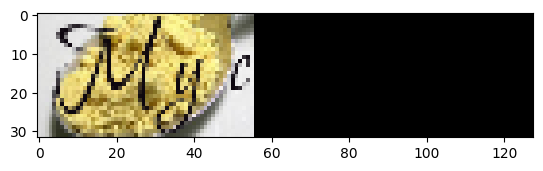

In [13]:
max_length = 20
recognition_image_generators = [
    convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=input_shape[1],
        target_height=input_shape[0],
        margin=1
    ) for image_generator in image_generators
]

# See what the first validation image for recognition training looks like.
image, text = next(recognition_image_generators[1])
print('This image contains:', text)
plt.imshow(image)

In [14]:
def get_generator_from_recognizer_input(generator, batch_size=recognizer_batch_size):
    while True:
        images = []
        texts = []
        for _ in range(batch_size): 
           image, text = next(generator)
           images.append(image/255)
           texts.append(text)
        texts = vectorization(texts)
        yield (
            {
                "encoder_inputs": tf.constant(images),
                "decoder_inputs": tf.constant(texts[:, :-1]),
            },
            tf.constant(texts[:, 1:]),
        )
test = next(get_generator_from_recognizer_input(recognition_image_generators[1]))

In [15]:
(test[1]).shape, test[0]['encoder_inputs'].shape,  test[0]['decoder_inputs'].shape, 

(TensorShape([64, 4]), TensorShape([64, 32, 128, 3]), TensorShape([64, 4]))

In [16]:
vectorization([text]), text

(<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 2,  1, 27, 25,  3]])>,
 'Мус')

In [17]:
custom_split([text])

<tf.RaggedTensor [[b'[bos]', b'\xd0\x9c', b'\xd1\x83', b'\xd1\x81', b'[eos]']]>

# TROCR

In [18]:
patch_size = 16
num_patches = input_shape[0]//patch_size * input_shape[1]//patch_size
projection_dim = 384

attention_heads = 6
intermediate_dim = 2048

In [19]:
import keras_nlp

Using TensorFlow backend


In [20]:
class PositionalEmbedding(keras.layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = keras.layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = inputs.shape[-1]
        positions =tf.range(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        else:
            return tf.ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

In [21]:
class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = tf.shape(images)
        # print(input_shape)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        # print(images, [1, self.patch_size, self.patch_size,1], [1, self.patch_size, self.patch_size, 1])
        patches = tf.image.extract_patches(images, 
                                           sizes=[1, self.patch_size, self.patch_size,1],
                                           strides=[1, self.patch_size, self.patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
        patches = tf.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.expand_dims(
            tf.range(start=0, limit=self.num_patches, delta=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [22]:
class TransformerDecoder(keras.layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.self_attention = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, name="self_attention"
        )
        self.cross_attention = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, name="cross_attention"
        )
        self.dense_proj = keras.Sequential(
            [
                keras.layers.Dense(latent_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = keras.layers.LayerNormalization()
        self.layernorm_2 = keras.layers.LayerNormalization()
        self.layernorm_3 = keras.layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):

        self_attention_output = self.self_attention(
            query=inputs, value=inputs, key=inputs
        )
        out_1 = self.layernorm_1(inputs + self_attention_output)
        
        cross_attention_output = self.cross_attention(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
        )
        out_2 = self.layernorm_2(out_1 + cross_attention_output)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = inputs.shape
  
        batch_size, sequence_length = tf.cast([input_shape[0], input_shape[1]], dtype='int32')
        i = tf.range(sequence_length)[:, None]
        j = tf.range(sequence_length)
  
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
     
        return tf.tile(mask, [batch_size,1,1])

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

In [23]:
num_patches, projection_dim

(16, 384)

In [24]:
def build_model():
    encoder_inputs = keras.layers.Input(shape=input_shape+(3,)) 
    patches = Patches(patch_size)(encoder_inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    encoded1 = keras_nlp.layers.TransformerEncoder(intermediate_dim=intermediate_dim, num_heads=attention_heads)(encoded_patches)
    encoded2 = keras_nlp.layers.TransformerEncoder(intermediate_dim=intermediate_dim, num_heads=attention_heads)(encoded1)
    # encoded3 = keras_nlp.layers.TransformerEncoder(intermediate_dim=intermediate_dim, num_heads=attention_heads)(encoded2)
    # encoded4 = keras_nlp.layers.TransformerEncoder(intermediate_dim=intermediate_dim, num_heads=attention_heads)(encoded3)
    
    # encoder = keras.Model(inputs=encoder_inputs, outputs=[encoded1, encoded2], name="VisionTransformerEncoder")
    # encoder.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.mean_squared_error)
    
    
    decoder_inputs = keras.layers.Input(shape=(sequence_length,))
    decoder_inputs_embedded = keras.layers.Embedding(input_dim=1, output_dim=projection_dim)(decoder_inputs)

    encoded_seq_inputs1 = keras.layers.Input(shape=(num_patches, projection_dim), name="encoder1 output")
    encoded_seq_inputs2 = keras.layers.Input(shape=(num_patches, projection_dim), name="encoder2 output")
    # encoded_seq_inputs3 = keras.layers.Input(shape=(num_patches, projection_dim), name="encoder3 output")
    # encoded_seq_inputs4 = keras.layers.Input(shape=(num_patches, projection_dim), name="encoder4 output")
    
    dec1_state = keras.layers.Add()([encoded_seq_inputs2,encoded_seq_inputs1])
    # dec2_state = keras.layers.Add()([encoded_seq_inputs4,encoded_seq_inputs3, encoded_seq_inputs2])
    # dec3_state = keras.layers.Add()([encoded_seq_inputs4,encoded_seq_inputs3])

    

        
    # cache = tf.expand_dims(encoded_seq_inputs, 1)
    # cache = tf.concat([cache, cache], axis=1)
    print(encoded2.shape, decoder_inputs_embedded.shape)
    decoded1 = TransformerDecoder(
        embed_dim=projection_dim, 
        latent_dim=vectorization.vocabulary_size(), 
        num_heads=attention_heads)(decoder_inputs_embedded, dec1_state)
    decoded1 = keras.layers.Dropout(0.1)(decoded1)
    decoded2 = TransformerDecoder(
        embed_dim=projection_dim, 
        latent_dim=vectorization.vocabulary_size(), 
        num_heads=attention_heads)(decoded1, encoded_seq_inputs2)
    decoded2 = keras.layers.Dropout(0.1)(decoded2)
    # decoded3 = TransformerDecoder(
    #     embed_dim=intermediate_dim, 
    #     latent_dim=vectorization.vocabulary_size(), 
    #     num_heads=attention_heads)(decoded2, dec3_state)
    # decoded4 = TransformerDecoder(
    #     embed_dim=intermediate_dim, 
    #     latent_dim=vectorization.vocabulary_size(), 
    #     num_heads=attention_heads)(decoded3, encoded_seq_inputs4)
    print(decoded1.shape)
    
    # decoded2 = keras_nlp.layers.TransformerDecoder(
    #     intermediate_dim=intermediate_dim, 
    #     num_heads=attention_heads)(decoded1, encoded_seq_inputs)
    
    logits = keras.layers.Dense(vectorization.vocabulary_size(), activation='softmax', name='output')(decoded2)
    
    decoder = keras.Model(inputs=[decoder_inputs, encoded_seq_inputs1, encoded_seq_inputs2,],
                          outputs=logits,
                          name="TransformerDecoder")
    
    
    decoder_outputs = decoder([decoder_inputs, encoded1, encoded2])
    
    
    transformer = keras.Model(
        inputs = {'encoder_inputs':encoder_inputs, 'decoder_inputs':decoder_inputs}, 
        outputs = decoder_outputs, name="TransformerModel"
    )
    return transformer
transformer = build_model()
transformer.summary()

(None, 16, 384) (None, 5, 384)
(None, 5, 384)
Model: "TransformerModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 32, 128, 3)]         0         []                            
                                                                                                  
 patches (Patches)           (None, 16, 768)              0         ['input_6[0][0]']             
                                                                                                  
 patch_encoder (PatchEncode  (None, 16, 384)              301440    ['patches[0][0]']             
 r)                                                                                               
                                                                                                  
 transformer_encoder (Trans  (None, 1

In [25]:
transformer.compile(optimizer=keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-2), 
                    loss=keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['sparse_top_k_categorical_accuracy', 'sparse_categorical_accuracy'])

In [26]:
print(transformer.layers[2])

In [ ]:
recognizer_basepath = os.path.join(data_dir, f'recogniser_{datetime.datetime.now().isoformat()}')

class_weights = {i:1. for i in range(transformer.output.shape[-1])}
class_weights[0]=10.
class_weights[2]=class_weights[3]=0.5

hist = {}
log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
!rm -rf ../logs/
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

for _ in range(5):
        
    
    train_data_generator, val_data_generator, test_data_generator = [ 
        get_generator_from_recognizer_input(generator) for generator in recognition_image_generators
    ]
    try:
        his = transformer.fit(
            train_data_generator, epochs=1000,
            steps_per_epoch=math.ceil(len(background_splits[0]) / recognizer_batch_size)*10,
        
            callbacks=[tensorboard_callback,
            tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=100, monitor='val_loss'),
            tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv'),
            tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.keras'),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, cooldown=20, patience=15, min_lr=1e-10)
            ],
            validation_data=val_data_generator,
            validation_steps=math.ceil(len(background_splits[1]) / recognizer_batch_size),
            batch_size=recognizer_batch_size,
            class_weight=class_weights
        )
    except Exception as e:
        print(e)
    else:
        for key in his.history.keys():
            if hist.get(key) is not None:
                hist[key] += his.history[key]
            else:
                hist[key] = his.history[key]

Epoch 1/1000


2024-03-01 16:39:40.329582: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-01 16:39:41.140515: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd273934370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-01 16:39:41.140541: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-03-01 16:39:41.144638: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709300381.221077   32098 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 [==============================] - 169s 1s/step - loss: 10.9216 - sparse_top_k_categorical_accuracy: 0.4282 - sparse_categorical_accuracy: 0.1681 - val_loss: 2.9176 - val_sparse_top_k_categorical_accuracy: 0.4844 - val_sparse_categorical_accuracy: 0.1777 - lr: 1.0000e-04
Epoch 2/1000
130/130 [==============================] - 154s 1s/step - loss: 10.2501 - sparse_top_k_categorical_accuracy: 0.4586 - sparse_categorical_accuracy: 0.1802 - val_loss: 2.8365 - val_sparse_top_k_categorical_accuracy: 0.5000 - val_sparse_categorical_accuracy: 0.1797 - lr: 1.0000e-04
Epoch 3/1000
 80/130 [=================>............] - ETA: 54s - loss: 10.0959 - sparse_top_k_categorical_accuracy: 0.4613 - sparse_categorical_accuracy: 0.1790

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [ ]:
tf.strings.unicode_split(["'Зало'", "'жить бетонн'", "'ый останови'", "'ть мелочь'", "'затян'", "'уться е'", "'врейс'", "'M'", "'ind growth'", "'born week s'", "'eem cons'", "'С'", "'т'", "'ро'", "'и'", "'т'"], 'UTF-8')

In [ ]:
vectorization(["'Зало'", "'жить бетонн'", "'ый останови'", "'ть мелочь'", "'затян'", "'уться е'", "'врейс'", "'M'", "'ind growth'", "'born week s'", "'eem cons'", "'С'", "'т'", "'ро'", "'и'", "'т'"])

In [ ]:
transformer.save('../models/TROCR.keras')

In [ ]:
evals = transformer.evaluate(test_data_generator, batch_size=recognizer_batch_size, steps=len(background_splits[-1])//recognizer_batch_size)

In [ ]:
evals

In [ ]:
import cv2

In [ ]:
word = cv2.imread('../data/word_gr.png')
word = cv2.resize(word, (input_shape[1],input_shape[0]))
plt.imshow(word)

In [ ]:
transformer.input

In [ ]:
dec_inp = [2] + [0]*(sequence_length-1)
dec_inp = np.array(dec_inp)[np.newaxis, :]
dec_inp.shape

In [ ]:
word.shape

In [ ]:
pred = transformer.predict({'encoder_inputs':word[np.newaxis,:,:,:],
                            'decoder_inputs':dec_inp})

In [ ]:
pred.argmax(axis=-1)